In [121]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils.utils import *
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import davies_bouldin_score

In [122]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
# Set up paths
script_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(script_dir, os.pardir))
tableu_dir = os.path.join(root_dir, 'tableau')
porcessed_data_dir = os.path.join(script_dir, 'processed_data')

In [124]:
output_df = pd.read_csv(os.path.join(tableu_dir, 'bardis_ensemble_python_ver_1000.csv'))
output_df

,Resources,Economy,Bureaucracy,Pollution,time,run_id
0,1.000000,1.000000,1.000000,1.000000,0.0,1.0
1,0.983784,1.000960,0.998752,1.016100,0.2,1.0
2,0.967711,1.001403,0.997471,1.031933,0.4,1.0
3,0.951795,1.001332,0.996156,1.047494,0.6,1.0
4,0.936050,1.000748,0.994805,1.062779,0.8,1.0
...,...,...,...,...,...,...
1000995,-0.000081,-0.000107,0.340252,0.059603,199.2,1000.0
1000996,-0.000081,-0.000107,0.339812,0.059526,199.4,1000.0
1000997,-0.000081,-0.000107,0.339372,0.059449,199.6,1000.0
1000998,-0.000081,-0.000107,0.338933,0.059372,199.8,1000.0


In [125]:
output_df.min()

Resources     -0.000550
Economy       -0.001095
Bureaucracy   -0.000631
Pollution     -0.033206
time           0.000000
run_id         1.000000
dtype: float64

In [126]:
fe = FeatureExtractor()
edau = EDAUtils()

# Time Series Clustering (Simple Approach)

## Create freatures df

In [127]:
transformed_output_df = output_df.groupby("run_id").apply(fe.extract_ts_features).reset_index()
transformed_output_df.head() 

/tmp/ipykernel_109211/2261743549.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  transformed_output_df = output_df.groupby("run_id").apply(fe.extract_ts_features).reset_index()


,run_id,Resources_final,Resources_max,Resources_min,Resources_auc,Resources_max_min_diff,Resources_final_min_diff,Resources_final_initial_diff,Resources_delta_5,Resources_delta_10,...,Pollution_delta_200,Pollution_max_0,Pollution_max_25,Pollution_max_50,Pollution_max_75,Pollution_max_100,Pollution_max_125,Pollution_max_150,Pollution_max_175,Pollution_max_200
0,1.0,7.483451e+07,7.483451e+07,0.459866,7.161183e+08,7.483451e+07,7.483451e+07,7.483451e+07,-0.054953,-0.021643,...,0.000000,1.486988,1.339070,0.905152,0.498049,-0.000012,-0.000012,-0.000012,-0.000012,-0.000012
1,2.0,-8.054008e-05,1.000000e+00,-0.000081,2.996052e+00,1.000081e+00,0.000000e+00,-1.000081e+00,-0.101365,0.000000,...,0.015364,1.000000,0.313674,0.361651,0.474211,0.623072,0.818771,1.075944,1.413895,1.413895
2,3.0,-1.693546e-04,1.000000e+00,-0.000169,4.514829e+00,1.000169e+00,0.000000e+00,-1.000169e+00,-0.090180,-0.035000,...,-0.000273,1.061755,0.686667,0.347329,0.186940,0.105739,0.061993,0.037224,0.022684,0.013939
3,4.0,-1.860879e-04,1.000000e+00,-0.000186,7.161374e+00,1.000186e+00,0.000000e+00,-1.000186e+00,-0.075484,-0.041547,...,-0.000435,1.278739,1.171494,0.763440,0.408059,0.215617,0.113876,0.060088,0.031651,0.016617
4,5.0,8.005388e+05,8.005388e+05,0.447694,1.033277e+07,8.005384e+05,8.005384e+05,8.005378e+05,-0.057644,-0.017476,...,0.000000,2.207168,2.676461,3.241694,3.899212,4.501506,4.568650,3.877037,-0.001063,-0.001063


In [128]:
transformed_output_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 157 entries, run_id to Pollution_max_200
dtypes: float64(157)
memory usage: 1.2 MB


## Data Cleaning

- Drop duplicates?

In [129]:
transformed_output_df.isnull().sum().sort_values(ascending=False).head()


run_id             0
Resources_final    0
Resources_max      0
Resources_min      0
Resources_auc      0
dtype: int64

In [130]:
# Check for duplicates
transformed_output_df.duplicated().sum()

np.int64(0)

In [131]:
# Drop run_id to create features dataframe
features_df = transformed_output_df.drop(columns=["run_id"])
features_df.head()

,Resources_final,Resources_max,Resources_min,Resources_auc,Resources_max_min_diff,Resources_final_min_diff,Resources_final_initial_diff,Resources_delta_5,Resources_delta_10,Resources_delta_15,...,Pollution_delta_200,Pollution_max_0,Pollution_max_25,Pollution_max_50,Pollution_max_75,Pollution_max_100,Pollution_max_125,Pollution_max_150,Pollution_max_175,Pollution_max_200
0,7.483451e+07,7.483451e+07,0.459866,7.161183e+08,7.483451e+07,7.483451e+07,7.483451e+07,-0.054953,-0.021643,0.011582,...,0.000000,1.486988,1.339070,0.905152,0.498049,-0.000012,-0.000012,-0.000012,-0.000012,-0.000012
1,-8.054008e-05,1.000000e+00,-0.000081,2.996052e+00,1.000081e+00,0.000000e+00,-1.000081e+00,-0.101365,0.000000,0.000000,...,0.015364,1.000000,0.313674,0.361651,0.474211,0.623072,0.818771,1.075944,1.413895,1.413895
2,-1.693546e-04,1.000000e+00,-0.000169,4.514829e+00,1.000169e+00,0.000000e+00,-1.000169e+00,-0.090180,-0.035000,-0.007415,...,-0.000273,1.061755,0.686667,0.347329,0.186940,0.105739,0.061993,0.037224,0.022684,0.013939
3,-1.860879e-04,1.000000e+00,-0.000186,7.161374e+00,1.000186e+00,0.000000e+00,-1.000186e+00,-0.075484,-0.041547,-0.025881,...,-0.000435,1.278739,1.171494,0.763440,0.408059,0.215617,0.113876,0.060088,0.031651,0.016617
4,8.005388e+05,8.005388e+05,0.447694,1.033277e+07,8.005384e+05,8.005384e+05,8.005378e+05,-0.057644,-0.017476,0.022456,...,0.000000,2.207168,2.676461,3.241694,3.899212,4.501506,4.568650,3.877037,-0.001063,-0.001063


## EDA

In [132]:
features_df.describe()

,Resources_final,Resources_max,Resources_min,Resources_auc,Resources_max_min_diff,Resources_final_min_diff,Resources_final_initial_diff,Resources_delta_5,Resources_delta_10,Resources_delta_15,...,Pollution_delta_200,Pollution_max_0,Pollution_max_25,Pollution_max_50,Pollution_max_75,Pollution_max_100,Pollution_max_125,Pollution_max_150,Pollution_max_175,Pollution_max_200
count,1.000000e+03,1.000000e+03,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,8.121650e+06,8.121651e+06,0.048360,7.475332e+07,8.121651e+06,8.121650e+06,8.121649e+06,-0.081520,-0.038607,-0.011129,...,0.003853,1.113417,0.664248,0.495307,0.421682,0.384513,0.371276,0.389012,0.424175,0.409404
std,6.342219e+07,6.342219e+07,0.156365,5.728352e+08,6.342219e+07,6.342219e+07,6.342219e+07,0.020271,0.014440,0.017734,...,0.052586,0.229273,0.514771,0.654326,0.865437,1.180666,1.591181,2.165128,3.054406,3.054179
min,-5.500524e-04,1.000000e+00,-0.000550,2.678457e+00,1.000000e+00,0.000000e+00,-1.000550e+00,-0.112355,-0.068857,-0.056835,...,-0.037931,1.000000,0.155129,0.112840,0.005173,-0.001423,-0.010701,-0.010701,-0.033206,-0.033206
25%,-2.098576e-04,1.000000e+00,-0.000210,4.231617e+00,1.000081e+00,0.000000e+00,-1.000210e+00,-0.096477,-0.047663,-0.025736,...,-0.000456,1.000000,0.317290,0.214574,0.154588,0.099662,0.052031,0.027880,0.012309,0.005531
50%,-1.238550e-04,1.000000e+00,-0.000124,5.459780e+00,1.000160e+00,0.000000e+00,-1.000124e+00,-0.086970,-0.041704,-0.001673,...,-0.000210,1.000000,0.486325,0.298171,0.220098,0.159191,0.119171,0.088373,0.063393,0.044315
75%,-4.328090e-05,1.000000e+00,-0.000043,7.934982e+00,1.000274e+00,0.000000e+00,-1.000043e+00,-0.070853,-0.033127,0.000000,...,0.000000,1.132907,0.852145,0.482671,0.361028,0.303357,0.250273,0.221742,0.190848,0.178247
max,1.003685e+09,1.003685e+09,0.899583,8.925059e+09,1.003685e+09,1.003685e+09,1.003685e+09,-0.003333,0.023164,0.102037,...,1.100327,2.774483,4.615555,7.674340,12.711471,20.466304,26.203690,38.297935,60.566934,60.566934


In [133]:
# edau.plot_histograms(features_df)

In [134]:
# # Correlation heatmap to inspect relationships between features
# plt.figure(figsize=(40, 20))
# sns.heatmap(features_df.corr(), annot=True, cmap="coolwarm")
# plt.title("Feature Correlation Heatmap")
# plt.show()

In [135]:
# Calculate skewness for numeric features in the DataFrame
skewness = features_df.skew(numeric_only=True)
# print("Skewness of features:\n", skewness)

# Define a threshold for high skewness, e.g., absolute skewness > 1
threshold = 1
skewed_features = skewness[abs(skewness) > threshold].index.tolist()
print("Skewed features:", skewed_features)


Skewed features: ['Resources_final', 'Resources_max', 'Resources_min', 'Resources_auc', 'Resources_max_min_diff', 'Resources_final_min_diff', 'Resources_final_initial_diff', 'Resources_delta_5', 'Resources_delta_10', 'Resources_delta_20', 'Resources_delta_25', 'Resources_delta_30', 'Resources_delta_40', 'Resources_delta_50', 'Resources_delta_60', 'Resources_delta_70', 'Resources_delta_80', 'Resources_delta_90', 'Resources_delta_100', 'Resources_delta_110', 'Resources_delta_120', 'Resources_delta_130', 'Resources_delta_140', 'Resources_delta_150', 'Resources_delta_160', 'Resources_delta_170', 'Resources_delta_180', 'Resources_delta_190', 'Resources_delta_200', 'Resources_max_0', 'Resources_max_25', 'Resources_max_50', 'Resources_max_75', 'Resources_max_100', 'Resources_max_125', 'Resources_max_150', 'Resources_max_175', 'Resources_max_200', 'Economy_final', 'Economy_max', 'Economy_min', 'Economy_auc', 'Economy_max_min_diff', 'Economy_final_min_diff', 'Economy_final_initial_diff', 'Econo

In [136]:
# features_df_no_skew = features_df.drop(columns=skewed_features)

In [137]:
# Histograms for each numeric feature
# edau.plot_histograms(features_df_no_skew)

In [138]:
# Log-transform the skewed features
features_df_log = features_df.copy()

# TODO: Only to skewed features or to all features?
features_df_log = edau.apply_log_transform(features_df_log, skewed_features)

Applied log1p with offset 1.0005500524134083 to column: Resources_final
Applied natural log to column: Resources_max
Applied log1p with offset 1.0005500524134083 to column: Resources_min
Applied natural log to column: Resources_auc
Applied natural log to column: Resources_max_min_diff
Applied log1p with offset 1.0 to column: Resources_final_min_diff
Applied log1p with offset 2.0005500524134083 to column: Resources_final_initial_diff
Applied log1p with offset 1.1123554638285296 to column: Resources_delta_5
Applied log1p with offset 1.0688570574580343 to column: Resources_delta_10
Applied log1p with offset 1.055934494625877 to column: Resources_delta_20
Applied log1p with offset 1.0440602049291448 to column: Resources_delta_25
Applied log1p with offset 1.0302959520465125 to column: Resources_delta_30
Applied log1p with offset 1.0247418221771103 to column: Resources_delta_40
Applied log1p with offset 1.2046207903854746 to column: Resources_delta_50
Applied log1p with offset 1.543457601974

In [139]:
# edau.plot_histograms(features_df_log)

## ECONOMY

In [140]:
features_df_log = features_df_log[[col for col in features_df_log.columns if col.startswith('Economy')]]
features_df_log

,Economy_final,Economy_max,Economy_min,Economy_auc,Economy_max_min_diff,Economy_final_min_diff,Economy_final_initial_diff,Economy_delta_5,Economy_delta_10,Economy_delta_15,...,Economy_delta_200,Economy_max_0,Economy_max_25,Economy_max_50,Economy_max_75,Economy_max_100,Economy_max_125,Economy_max_150,Economy_max_175,Economy_max_200
0,0.693397,0.001402,0.693397,2.309399,0.001997,0.693147,0.693397,-0.046200,-0.077815,-0.086890,...,0.711230,1.001403,-0.000595,0.693397,0.693397,0.693397,0.693397,0.693397,0.693397,0.693397
1,1.721403,1.278507,0.960981,5.711925,1.091289,1.605051,1.721403,-0.021333,-0.045556,-0.025191,...,0.730211,1.163173,0.701352,1.070602,1.164786,1.276379,1.406282,1.554766,1.721403,1.721403
2,0.693607,0.116756,0.693607,2.764029,0.116912,0.693147,0.693607,-0.021476,-0.066213,-0.065325,...,0.711230,1.123845,0.007114,0.693607,0.693607,0.693607,0.693607,0.693607,0.693607,0.693607
3,0.693385,0.042145,0.693385,2.554968,0.042737,0.693147,0.693385,-0.028226,-0.068854,-0.075384,...,0.711230,1.043046,-0.000618,0.693385,0.693385,0.693385,0.693385,0.693385,0.693385,0.693385
4,0.693636,0.006598,0.693636,2.321819,0.006713,0.693147,0.693636,-0.044061,-0.083774,-0.103695,...,0.711230,1.006620,-0.000116,0.693636,0.693636,0.693636,0.693636,0.693636,0.693636,0.693636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.698650,0.049428,0.698650,3.467997,0.039922,0.693147,0.698650,-0.011233,-0.036616,-0.040133,...,0.711156,1.050670,0.394517,0.766219,0.733060,0.717939,0.709534,0.704337,0.700936,0.698650
996,0.693536,0.158403,0.693536,2.807359,0.158674,0.693147,0.693536,-0.018434,-0.074149,-0.063339,...,0.711230,1.171638,0.037296,0.693536,0.693536,0.693536,0.693536,0.693536,0.693536,0.693536
997,0.693655,0.615136,0.693655,4.336397,0.615179,0.693147,0.693655,-0.025020,-0.028615,-0.026710,...,0.711230,1.000000,0.396591,1.348334,1.344070,0.891399,0.700563,0.693655,0.693655,0.693655
998,0.693492,0.000625,0.693492,2.554909,0.001029,0.693147,0.693492,-0.034943,-0.053422,-0.054566,...,0.711230,1.000625,-0.000404,0.693492,0.693492,0.693492,0.693492,0.693492,0.693492,0.693492


## Preprocess data

- Drop redoundant variables?
- Drop vars that have very thight distributions?

In [141]:
# Scale the features
# X = features_df.drop(columns=["run_id"])
X = features_df_log.copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled.shape

(1000, 39)

Number of components selected: 9


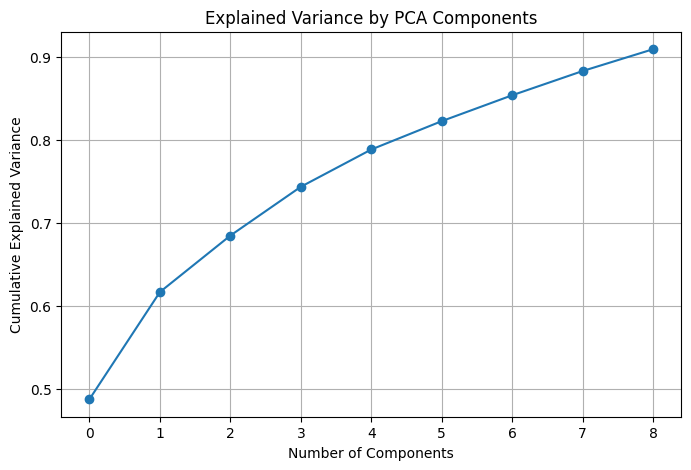

In [142]:
# Retain enough components to explain 90% of the variance
pca = PCA(n_components=0.9, random_state=42)
df_pca = pca.fit_transform(X_scaled)



print("Number of components selected:", pca.n_components_)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.grid(True)
plt.show()

Explained variance ratio for all components: [4.87324074e-01 1.29405799e-01 6.81433600e-02 5.88974301e-02
 4.50060949e-02 3.42255478e-02 3.12413517e-02 2.92577610e-02
 2.63257223e-02 2.15220121e-02 1.90988569e-02 1.17383510e-02
 8.79800277e-03 6.82071258e-03 5.75196349e-03 4.96377940e-03
 4.30663697e-03 3.30080579e-03 1.47951780e-03 6.00714960e-04
 5.14722316e-04 3.55227166e-04 3.45773808e-04 2.98104036e-04
 1.20165542e-04 8.54687022e-05 3.02011038e-05 2.71817518e-05
 7.78335888e-06 4.04374408e-06 2.26404287e-06 3.99400933e-07
 1.04988717e-07 3.27432450e-08 2.89158815e-08 3.22873108e-09
 5.76646301e-10 0.00000000e+00 0.00000000e+00]


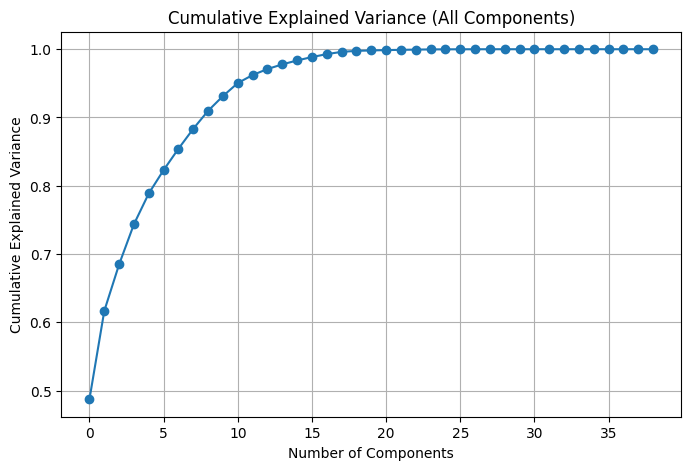

In [143]:
pca_full = PCA(n_components=None, random_state=42)
df_pca_full = pca_full.fit_transform(X_scaled)
print("Explained variance ratio for all components:", pca_full.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance (All Components)")
plt.grid(True)
plt.show()


In [144]:
# # Each row = feature, each column = principal component
# loadings = pd.DataFrame(
#     pca_full.components_.T,  # Transpose to have features as rows
#     index=features_df_log.columns,  # Feature names
#     columns=[f'PC{i+1}' for i in range(pca_full.n_components_)]
# )

# # Select top N components to visualize
# top_n = 5
# plt.figure(figsize=(12, min(0.5 * len(loadings), 12)))
# sns.heatmap(loadings.iloc[:, :top_n], annot=True, cmap='coolwarm', center=0)
# plt.title(f"PCA Loadings (Top {top_n} Components)")
# plt.xlabel("Principal Components")
# plt.ylabel("Original Features")
# plt.tight_layout()
# plt.show()

# # Create a dataframe that shows the relationship between the components and the original variables
# df_pca_comp = pd.DataFrame(data = pca.components_,
#                            columns = features_df_log.columns)

# # Create the Heat Map for Principal Components against original features. Again we use the RdBu color scheme and set borders to -1 and 1.
# plt.figure(figsize=(70,10))
# sns.heatmap(df_pca_comp,
#             vmin = -1, 
#             vmax = 1,
#             cmap = 'RdBu',
#             annot = True)

# plt.title('Components vs Original Features',fontsize = 14)
# plt.show()

In [145]:
np.cumsum(pca.explained_variance_ratio_)

array([0.48732407, 0.61672987, 0.68487323, 0.74377066, 0.78877676,
       0.82300231, 0.85424366, 0.88350142, 0.90982714])

In [146]:
df_pca.shape

(1000, 9)

In [147]:
rows_n = df_pca.shape[0]

## Train Models

### Visualization Functions

### K means

In [148]:
def plot_clusters(df, clusters, principal_component_x=0, principal_component_y=1, principal_component_z=None):
    """
    Plots clusters using 2D or 3D PCA-transformed data.

    Parameters:
    - df: ndarray or DataFrame with PCA components
    - clusters: cluster labels
    - principal_component_x, principal_component_y: indexes of PCA components for 2D plot
    - principal_component_z: index of third component for 3D plot (optional)
    """
    
    if principal_component_z is not None and df.shape[1] > principal_component_z:
        # 3D Plot
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(
            df[:, principal_component_x], 
            df[:, principal_component_y], 
            df[:, principal_component_z], 
            c=clusters, cmap="plasma", edgecolor='k'
        )
        ax.set_xlabel(f"Principal Component {principal_component_x + 1}")
        ax.set_ylabel(f"Principal Component {principal_component_y + 1}")
        ax.set_zlabel(f"Principal Component {principal_component_z + 1}")
        ax.set_title("Cluster Visualization (PCA 3D)")

        # Create legend
        unique_clusters = np.unique(clusters)
        handles = [
            mpatches.Patch(color=scatter.cmap(scatter.norm(cl)), label=f"Cluster {cl}")
            for cl in unique_clusters
        ]
        ax.legend(handles=handles, title="Cluster Label", loc="upper left")
        plt.show()

    elif df.shape[1] >= 2:
        # 2D Plot
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(
            df[:, principal_component_x], 
            df[:, principal_component_y], 
            c=clusters, cmap="plasma", edgecolor='k'
        )
        plt.xlabel(f"Principal Component {principal_component_x + 1}")
        plt.ylabel(f"Principal Component {principal_component_y + 1}")
        plt.title("Cluster Visualization (PCA 2D)")
        plt.grid(True)

        unique_clusters = np.unique(clusters)
        handles = [
            mpatches.Patch(color=scatter.cmap(scatter.norm(cl)), label=f"Cluster {cl}")
            for cl in unique_clusters
        ]
        plt.legend(handles=handles, title="Cluster Label", loc="best")
        plt.show()
    
    else:
        print("Not enough components to visualize clusters.")
        
    return None


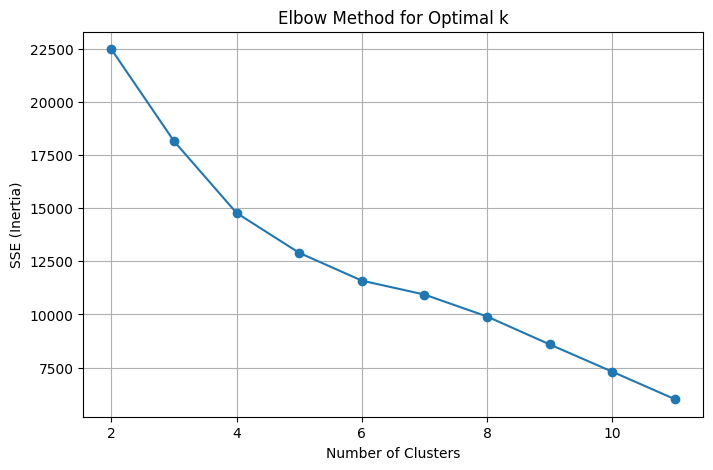

In [149]:
sse = []
k_range = range(2, 12)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_pca)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(list(k_range), sse, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("SSE (Inertia)")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()


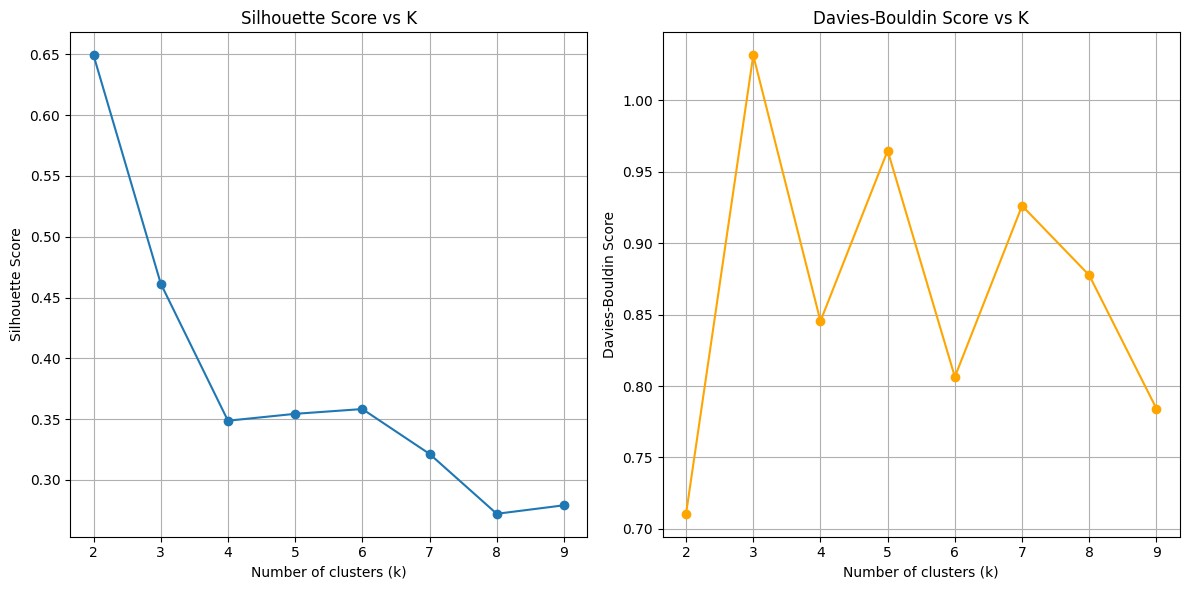

In [150]:
# Define the range of k (number of clusters) to test
k_values = range(2, 10) 

results = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(df_pca)
    
    # Evaluate scores
    silhouette = silhouette_score(df_pca, labels)
    dbi = davies_bouldin_score(df_pca, labels)

    results.append({
        "k": k,
        "silhouette_score": silhouette,
        "davies_bouldin": dbi
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(results_df["k"], results_df["silhouette_score"], marker='o')
plt.title("Silhouette Score vs K")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(results_df["k"], results_df["davies_bouldin"], marker='o', color='orange')
plt.title("Davies-Bouldin Score vs K")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Davies-Bouldin Score")
plt.grid(True)

plt.tight_layout()
plt.show()

In [151]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
clusters_kmeans = kmeans.fit_predict(df_pca)

# Evaluate clustering quality
sil_score = silhouette_score(df_pca, clusters_kmeans)
print("Silhouette Score:", sil_score)

dbi = davies_bouldin_score(df_pca, clusters_kmeans)
print(f"Davies-Bouldin Score: {dbi:.3f}")

Silhouette Score: 0.46144086888631713
Davies-Bouldin Score: 1.032


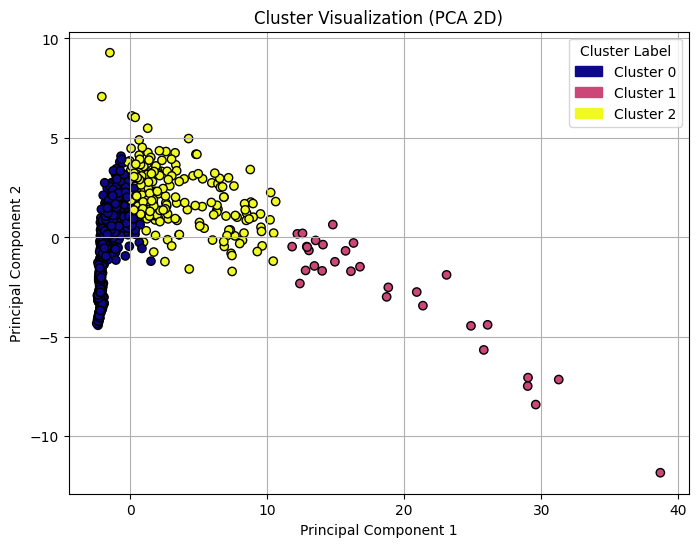

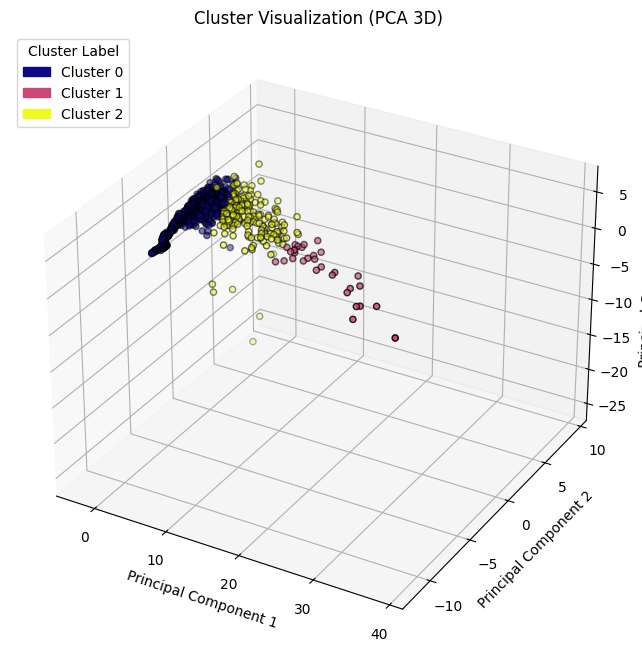

In [152]:
# Plot KMeans clusters from different PCA components

plot_clusters(df_pca, clusters_kmeans)
# plot_clusters(df_pca, clusters_kmeans, 0, 2)
# plot_clusters(df_pca, clusters_kmeans, 0, 3)
# plot_clusters(df_pca, clusters_kmeans, 0 ,4)
# plot_clusters(df_pca, clusters_kmeans, 1 ,2)
plot_clusters(df_pca, clusters_kmeans, 0, 1, 2)

### DBSCAN

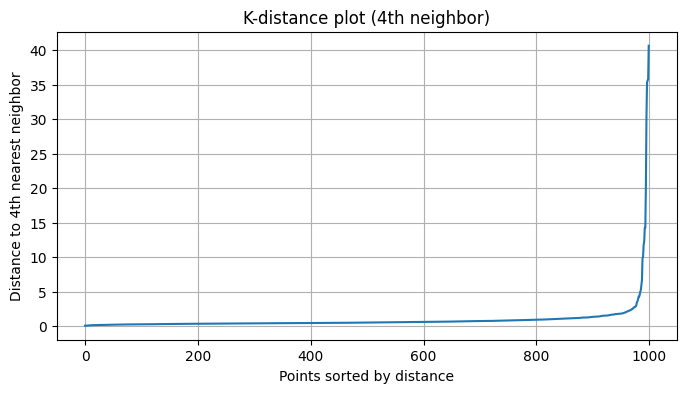

In [153]:
# Fit nearest neighbors
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(df_pca)
distances, indices = neighbors_fit.kneighbors(df_pca)

# Sort distances to find the "knee" point
distances = np.sort(distances[:, 4])  # 4th nearest neighbor distance
plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.title("K-distance plot (4th neighbor)")
plt.xlabel("Points sorted by distance")
plt.ylabel("Distance to 4th nearest neighbor")
plt.grid(True)
plt.show()


In [154]:
# Try some values first
dbscan = DBSCAN(eps=5, min_samples=5)  # Adjust eps based on elbow plot
dbscan.fit(df_pca)

# Add cluster labels to original dataframe
labels = dbscan.labels_  # -1 means noise


In [155]:
# # Exclude noise points
# mask = labels != -1
# if len(set(labels)) > 1 and sum(mask) > 1:
#     score = silhouette_score(df_pca[mask], labels[mask])
#     print(f"Silhouette Score: {score:.3f}")
# else:
#     print("Not enough clusters (or too much noise) to compute silhouette score.")

    

# if len(set(labels)) > 1 and sum(mask) > 1:
#     dbi = davies_bouldin_score(df_pca[mask], labels[mask])
#     print(f"Davies-Bouldin Index: {dbi:.3f}")



In [156]:

# Define the eps range and min_samples
eps_values = np.arange(0.5, 15.0, 0.1)  # Adjust based on your k-distance plot
min_samples = 5

results = []

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(df_pca)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    # Mask for non-noise points
    mask = labels != -1
    
    # Only evaluate if we have at least 2 clusters and some valid points
    if n_clusters >= 2 and np.sum(mask) > 10:
        silhouette = silhouette_score(df_pca[mask], labels[mask])
        dbi = davies_bouldin_score(df_pca[mask], labels[mask])
    else:
        silhouette = np.nan
        dbi = np.nan
    
    results.append({
        "eps": eps,
        "clusters": n_clusters,
        "noise_points": n_noise,
        "silhouette_score": silhouette,
        "davies_bouldin": dbi
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

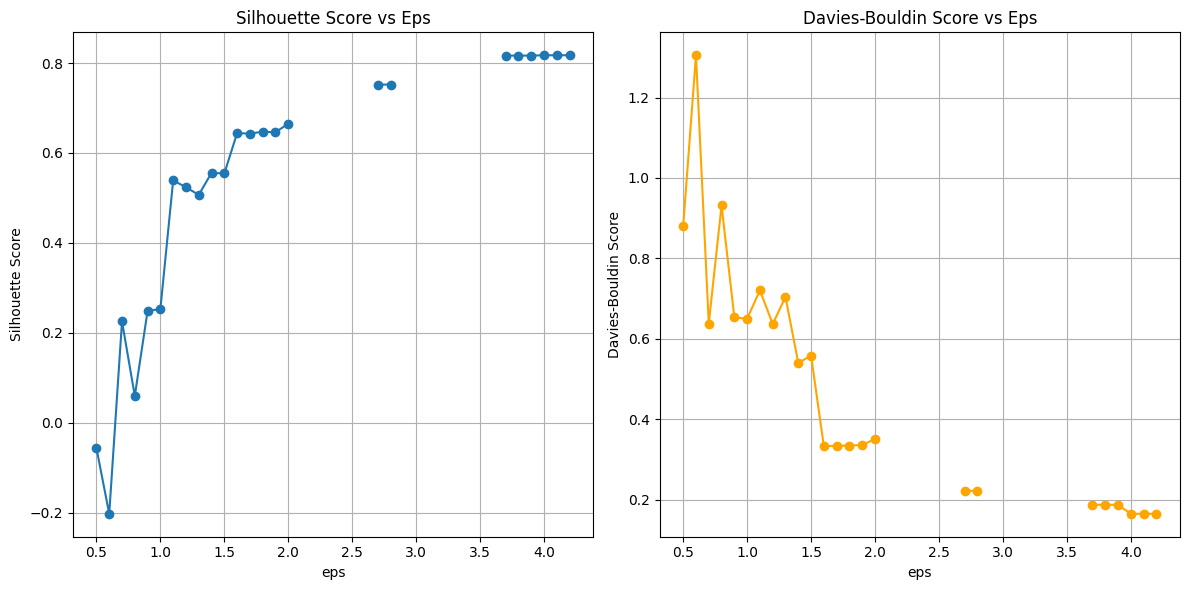

In [157]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(results_df["eps"], results_df["silhouette_score"], marker='o')
plt.title("Silhouette Score vs Eps")
plt.xlabel("eps")
plt.ylabel("Silhouette Score")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(results_df["eps"], results_df["davies_bouldin"], marker='o', color='orange')
plt.title("Davies-Bouldin Score vs Eps")
plt.xlabel("eps")
plt.ylabel("Davies-Bouldin Score")
plt.grid(True)

plt.tight_layout()
plt.show()

In [158]:
eps = 1.7

dbscan = DBSCAN(eps=eps, min_samples=5)
dbscan.fit(df_pca)

# Add cluster labels to original dataframe
labels = dbscan.labels_  # -1 means noise


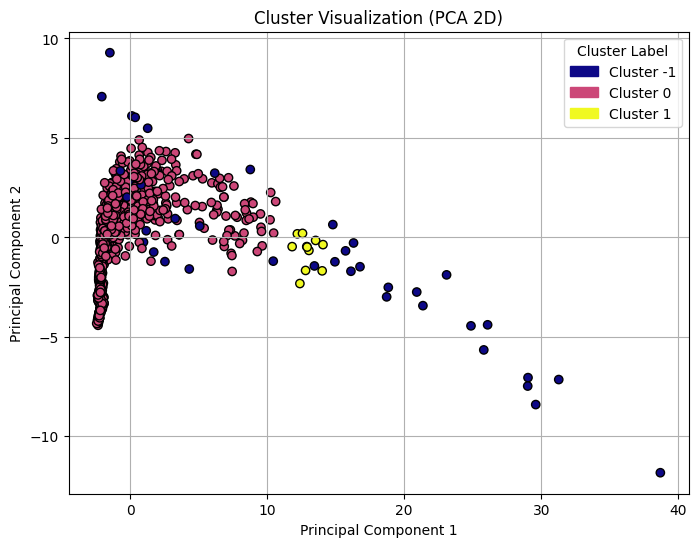

In [159]:
# Plot DBSCAN clusters from different PCA components
plot_clusters(df_pca, labels)

## Add Labels to Output Df

In [160]:
transformed_output_df.head()

,run_id,Resources_final,Resources_max,Resources_min,Resources_auc,Resources_max_min_diff,Resources_final_min_diff,Resources_final_initial_diff,Resources_delta_5,Resources_delta_10,...,Pollution_delta_200,Pollution_max_0,Pollution_max_25,Pollution_max_50,Pollution_max_75,Pollution_max_100,Pollution_max_125,Pollution_max_150,Pollution_max_175,Pollution_max_200
0,1.0,7.483451e+07,7.483451e+07,0.459866,7.161183e+08,7.483451e+07,7.483451e+07,7.483451e+07,-0.054953,-0.021643,...,0.000000,1.486988,1.339070,0.905152,0.498049,-0.000012,-0.000012,-0.000012,-0.000012,-0.000012
1,2.0,-8.054008e-05,1.000000e+00,-0.000081,2.996052e+00,1.000081e+00,0.000000e+00,-1.000081e+00,-0.101365,0.000000,...,0.015364,1.000000,0.313674,0.361651,0.474211,0.623072,0.818771,1.075944,1.413895,1.413895
2,3.0,-1.693546e-04,1.000000e+00,-0.000169,4.514829e+00,1.000169e+00,0.000000e+00,-1.000169e+00,-0.090180,-0.035000,...,-0.000273,1.061755,0.686667,0.347329,0.186940,0.105739,0.061993,0.037224,0.022684,0.013939
3,4.0,-1.860879e-04,1.000000e+00,-0.000186,7.161374e+00,1.000186e+00,0.000000e+00,-1.000186e+00,-0.075484,-0.041547,...,-0.000435,1.278739,1.171494,0.763440,0.408059,0.215617,0.113876,0.060088,0.031651,0.016617
4,5.0,8.005388e+05,8.005388e+05,0.447694,1.033277e+07,8.005384e+05,8.005384e+05,8.005378e+05,-0.057644,-0.017476,...,0.000000,2.207168,2.676461,3.241694,3.899212,4.501506,4.568650,3.877037,-0.001063,-0.001063


In [161]:
# Add cluster labels to the transformed DataFrame
transformed_output_df["kmeans_cluster_id"] = clusters_kmeans
transformed_output_df["dbscan_cluster_id"] = labels
# Save the transformed DataFrame with cluster labels
transformed_output_df.to_csv(os.path.join(porcessed_data_dir, f'transformed_output_with_{k}_clusters.csv'), index=False)

# Create a new df to map run_id to cluster_id
cluster_mapping_df = transformed_output_df[["run_id", "kmeans_cluster_id", "dbscan_cluster_id"]]

cluster_mapping_df

,run_id,kmeans_cluster_id,dbscan_cluster_id
0,1.0,0,0
1,2.0,1,1
2,3.0,0,0
3,4.0,0,0
4,5.0,0,0
...,...,...,...
995,996.0,0,0
996,997.0,0,0
997,998.0,0,-1
998,999.0,0,0


In [162]:
# Check for duplicates in the mapping DataFrame
print('duplicates: ', cluster_mapping_df.duplicated().sum())
# Check for null values in the mapping DataFrame
print('null values: \n', cluster_mapping_df.isnull().sum())

duplicates:  0
null values: 
 run_id               0
kmeans_cluster_id    0
dbscan_cluster_id    0
dtype: int64


In [163]:
output_df.head()

,Resources,Economy,Bureaucracy,Pollution,time,run_id
0,1.000000,1.000000,1.000000,1.000000,0.0,1.0
1,0.983784,1.000960,0.998752,1.016100,0.2,1.0
2,0.967711,1.001403,0.997471,1.031933,0.4,1.0
3,0.951795,1.001332,0.996156,1.047494,0.6,1.0
4,0.936050,1.000748,0.994805,1.062779,0.8,1.0


In [164]:
# Merge the cluster mapping DataFrame with the original output DataFrame
output_df_with_labels = output_df.merge(cluster_mapping_df, on="run_id", how="left")
output_df_with_labels.head()

,Resources,Economy,Bureaucracy,Pollution,time,run_id,kmeans_cluster_id,dbscan_cluster_id
0,1.000000,1.000000,1.000000,1.000000,0.0,1.0,0,0
1,0.983784,1.000960,0.998752,1.016100,0.2,1.0,0,0
2,0.967711,1.001403,0.997471,1.031933,0.4,1.0,0,0
3,0.951795,1.001332,0.996156,1.047494,0.6,1.0,0,0
4,0.936050,1.000748,0.994805,1.062779,0.8,1.0,0,0


In [165]:
output_df_with_labels.tail()

,Resources,Economy,Bureaucracy,Pollution,time,run_id,kmeans_cluster_id,dbscan_cluster_id
1000995,-0.000081,-0.000107,0.340252,0.059603,199.2,1000.0,0,0
1000996,-0.000081,-0.000107,0.339812,0.059526,199.4,1000.0,0,0
1000997,-0.000081,-0.000107,0.339372,0.059449,199.6,1000.0,0,0
1000998,-0.000081,-0.000107,0.338933,0.059372,199.8,1000.0,0,0
1000999,-0.000081,-0.000107,0.338494,0.059295,200.0,1000.0,0,0


In [166]:
# Sanity check that each run id is only in one cluster
output_df_with_labels.groupby("run_id")["kmeans_cluster_id"].nunique().value_counts()

kmeans_cluster_id
1    1000
Name: count, dtype: int64

In [167]:
# Save the output DataFrame with cluster labels
output_df_with_labels.to_csv(os.path.join(porcessed_data_dir, f'bardis_ensemble_python_ver_{rows_n}_k{k}_eps{eps}.csv'), index=False)